## 📝 Homework 1 Summary

### Part 1 – Multi-Armed Bandit
- **Run** the BanditLab notebook with at least three exploration strategies (ε-greedy with different ε, UCB, Softmax).
- ε-greedy with different ε means to compare different ε values and select one to compare agains UCB and Softmax. A similar strategy might be needed regarding temperature at Softmax and exploratory constant in UCB.

- **Collect**:
  - Average reward vs. time
  - % Optimal action vs. time
- **Write** a short paragraph explaining:
  - How exploration parameter (ε, c, τ) affected performance
  - Which strategy seemed best and why

### Part 2 – FrozenLake MDP (due after Session 2)
- **Run** the FrozenLake notebook:
  - Print number of states and actions
  - Inspect sample transition probabilities
  - Run ≥20 random-policy episodes; compute average reward and episode length
  - Estimate
- **Write** a short paragraph explaining:
  - Differences between FrozenLake and the bandit problem
  - What an agent might need to improve performance

### Deliverables
- Submit both notebooks (with plots and outputs).
- Submit the two reflection paragraphs (one per part).


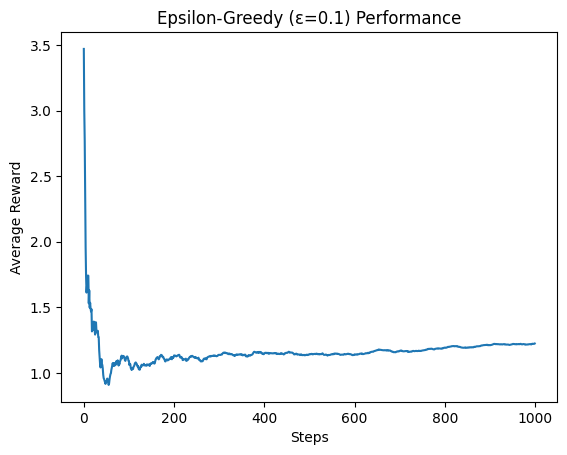

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class Bandit:
    def __init__(self, n_arms):
        self.n_arms = n_arms
        # true means of each arm (hidden from agent)
        self.true_means = np.random.normal(0, 1, n_arms)
        self.estimates = np.zeros(n_arms)
        self.counts = np.zeros(n_arms)

    def pull(self, arm):
        # stochastic reward from selected arm
        return np.random.normal(self.true_means[arm], 1)

    def update_estimate(self, arm, reward):
        self.counts[arm] += 1
        alpha = 1 / self.counts[arm]
        self.estimates[arm] += alpha * (reward - self.estimates[arm])

def epsilon_greedy(estimates, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(len(estimates))
    else:
        return np.argmax(estimates)

# Example run
bandit = Bandit(n_arms=10)
epsilon = 0.1
rewards = []

for t in range(1000):
    action = epsilon_greedy(bandit.estimates, epsilon)
    reward = bandit.pull(action)
    bandit.update_estimate(action, reward)
    rewards.append(reward)

plt.plot(np.cumsum(rewards) / np.arange(1, len(rewards)+1))
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.title(f'Epsilon-Greedy (ε={epsilon}) Performance')
plt.show()


In [2]:
class BanditEnv:
    def __init__(self, n, sigma=1.0, seed=0, nonstationary=False, drift=0.01):
        rng = np.random.default_rng(seed)
        self.n, self.sigma, self.rng = n, sigma, rng
        self.mu = rng.normal(0, 1, n)     # hidden true means
        self.nonstationary, self.drift = nonstationary, drift
    def step(self, a):
        if self.nonstationary:
            self.mu += self.rng.normal(0, self.drift, self.n)  # gentle random walk
        r = self.rng.normal(self.mu[a], self.sigma)
        return float(r)

class EpsilonGreedyAgent:
    def __init__(self, n, epsilon=0.1):
        self.epsilon = epsilon
        self.Q = np.zeros(n); self.N = np.zeros(n, dtype=int)
    def act(self):
        return np.random.randint(len(self.Q)) if np.random.rand() < self.epsilon else int(np.argmax(self.Q))
    def update(self, a, r):
        self.N[a] += 1
        self.Q[a] += (r - self.Q[a]) / self.N[a]


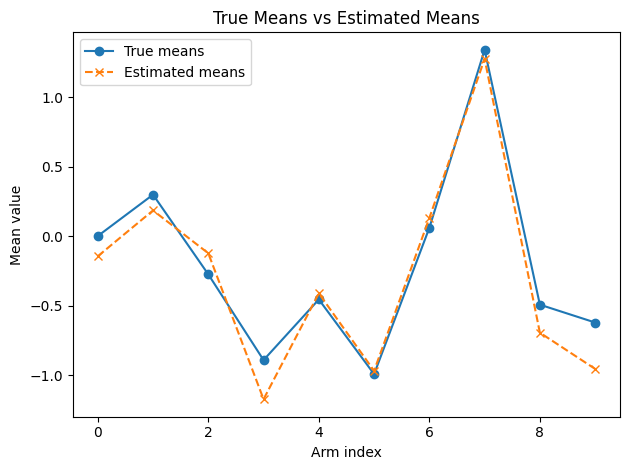

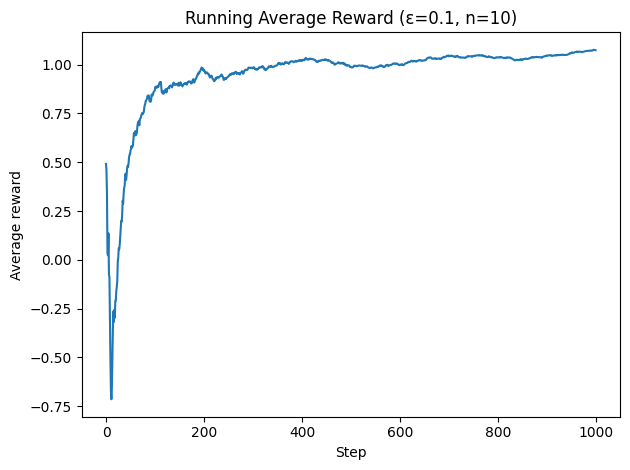

Best arm: 7 (true mean=1.340)
Agent thinks best arm: 7 (estimated mean=1.275)
Final average reward: 1.074


In [3]:
# --- Run an experiment with the BanditEnv and EpsilonGreedyAgent ---

# Parameters you can tweak
n_arms = 10          # number of arms
epsilon = 0.1        # exploration rate
steps = 1000         # total steps
seed = 7             # random seed for reproducibility
nonstationary = False
drift = 0.01         # drift if nonstationary=True

# Create environment and agent
env = BanditEnv(n=n_arms, seed=seed, nonstationary=nonstationary, drift=drift)
agent = EpsilonGreedyAgent(n=n_arms, epsilon=epsilon)

# Lists to store actions and rewards
rewards = []
actions = []

# Main loop
for t in range(steps):
    a = agent.act()            # select action
    r = env.step(a)            # get reward from environment
    agent.update(a, r)         # update estimate
    rewards.append(r)
    actions.append(a)

# Convert to numpy arrays
import numpy as np
rewards = np.array(rewards, dtype=float)
avg_reward = np.cumsum(rewards) / np.arange(1, steps + 1)

# --- Plot current estimates vs true means ---
import matplotlib.pyplot as plt

plt.figure()
x = np.arange(n_arms)
plt.plot(x, env.mu, marker='o', linestyle='-', label='True means')
plt.plot(x, agent.Q, marker='x', linestyle='--', label='Estimated means')
plt.xlabel('Arm index')
plt.ylabel('Mean value')
plt.title('True Means vs Estimated Means')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# --- Plot average reward over time ---
plt.figure()
plt.plot(avg_reward)
plt.xlabel('Step')
plt.ylabel('Average reward')
plt.title(f'Running Average Reward (ε={epsilon}, n={n_arms})')
plt.tight_layout()
plt.show()

# Quick summary
best_arm = int(np.argmax(env.mu))
estimated_best = int(np.argmax(agent.Q))
print(f"Best arm: {best_arm} (true mean={env.mu[best_arm]:.3f})")
print(f"Agent thinks best arm: {estimated_best} (estimated mean={agent.Q[estimated_best]:.3f})")
print(f"Final average reward: {avg_reward[-1]:.3f}")


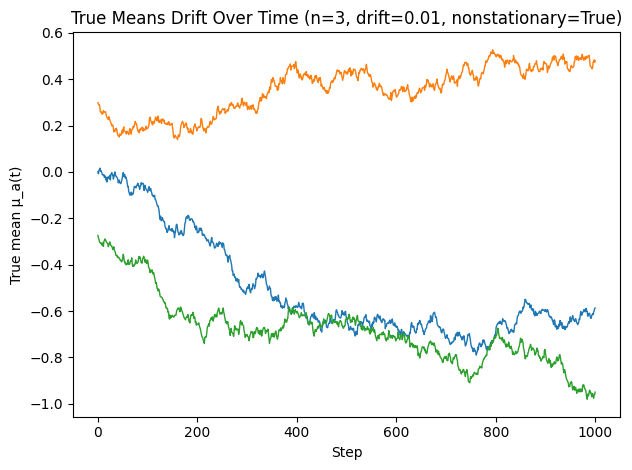

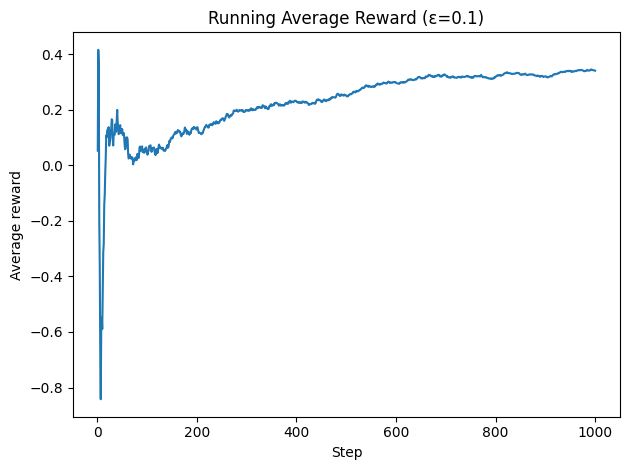

Final best arm: 1 (true mean=0.480)
Agent's estimated best: 1 (Q=0.384)
Total best-arm switches observed: 0


In [4]:
# --- Run an experiment and visualize DRIFT of true means over time ---

# Parameters
n_arms = 3
epsilon = 0.1
steps = 1000
seed = 7
nonstationary = True   # set True to see drift
drift = 0.01           # magnitude of random-walk per step (std dev)

# Create environment and agent
env = BanditEnv(n=n_arms, seed=seed, nonstationary=nonstationary, drift=drift)
agent = EpsilonGreedyAgent(n=n_arms, epsilon=epsilon)

# Storage
import numpy as np
rewards = np.empty(steps, dtype=float)
actions = np.empty(steps, dtype=int)
mu_hist = np.empty((steps+1, n_arms), dtype=float)  # store mu BEFORE each step (t=0..steps)
best_arm_hist = np.empty(steps+1, dtype=int)

# Initial snapshot of means & best arm
mu_hist[0] = env.mu.copy()
best_arm_hist[0] = int(np.argmax(mu_hist[0]))

# Main loop
for t in range(steps):
    a = agent.act()
    r = env.step(a)
    agent.update(a, r)
    rewards[t] = r
    actions[t] = a
    mu_hist[t+1] = env.mu.copy()
    best_arm_hist[t+1] = int(np.argmax(mu_hist[t+1]))

# Metrics
avg_reward = np.cumsum(rewards) / np.arange(1, steps + 1)
best_arm_switches = int(np.sum(best_arm_hist[1:] != best_arm_hist[:-1]))

# --- Plots ---
import matplotlib.pyplot as plt

# 1) True means over time (shows drift and possible best-arm swaps)
plt.figure()
time = np.arange(steps+1)
for a in range(n_arms):
    plt.plot(time, mu_hist[:, a], linewidth=1)
plt.xlabel('Step')
plt.ylabel('True mean μ_a(t)')
plt.title(f'True Means Drift Over Time (n={n_arms}, drift={drift}, nonstationary={nonstationary})')
plt.tight_layout()
plt.show()

# 2) Running average reward
plt.figure()
plt.plot(np.arange(1, steps+1), avg_reward)
plt.xlabel('Step')
plt.ylabel('Average reward')
plt.title(f'Running Average Reward (ε={epsilon})')
plt.tight_layout()
plt.show()



# Quick summary
final_best = int(np.argmax(env.mu))
print(f"Final best arm: {final_best} (true mean={env.mu[final_best]:.3f})")
print(f"Agent's estimated best: {int(np.argmax(agent.Q))} (Q={agent.Q.max():.3f})")
print(f"Total best-arm switches observed: {best_arm_switches}")


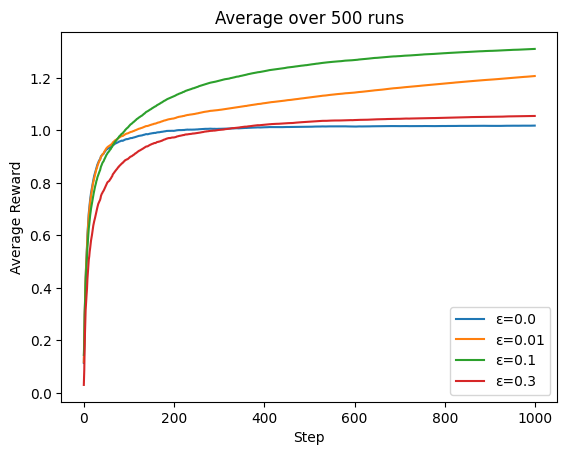

In [5]:
epsilons = [0.0, 0.01, 0.1, 0.3]
runs = 500          # large number
steps = 1000
n_arms = 10

avg_rewards_all = {eps: np.zeros(steps) for eps in epsilons}

for eps in epsilons:
    for run in range(runs):
        env = BanditEnv(n=n_arms, seed=run, nonstationary=False)
        agent = EpsilonGreedyAgent(n=n_arms, epsilon=eps)
        for t in range(steps):
            a = agent.act()
            r = env.step(a)
            agent.update(a, r)
            avg_rewards_all[eps][t] += r
    avg_rewards_all[eps] /= runs

plt.figure()
for eps in epsilons:
    avg_reward = np.cumsum(avg_rewards_all[eps]) / np.arange(1, steps+1)
    plt.plot(avg_reward, label=f'ε={eps}')
plt.xlabel('Step'); plt.ylabel('Average Reward')
plt.title(f'Average over {runs} runs')
plt.legend()
plt.show()


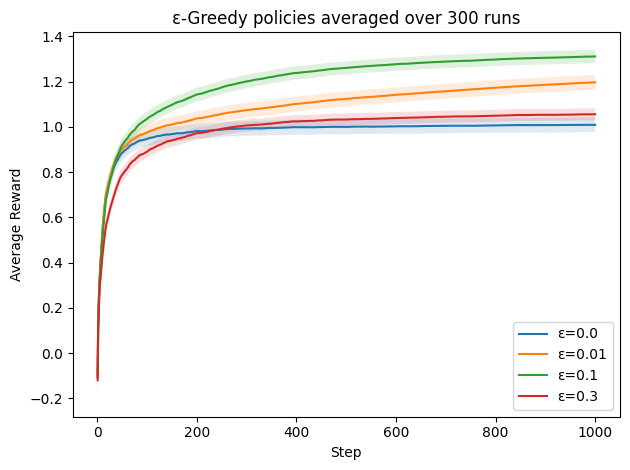

In [6]:
import numpy as np
import matplotlib.pyplot as plt

epsilons = [0.0, 0.01, 0.1, 0.3]
runs = 300
steps = 1000
n_arms = 10
nonstationary = False
drift = 0.01

def run_once(eps, seed):
    env = BanditEnv(n=n_arms, seed=seed, nonstationary=nonstationary, drift=drift)
    agent = EpsilonGreedyAgent(n=n_arms, epsilon=eps)
    r = np.empty(steps, dtype=float)
    for t in range(steps):
        a = agent.act()
        r[t] = env.step(a)
        agent.update(a, r[t])
    # running average reward
    return np.cumsum(r) / np.arange(1, steps+1)

means = {}
stds  = {}

for eps in epsilons:
    curves = np.zeros((runs, steps), dtype=float)
    for i in range(runs):
        seed = 10_000 + i                    # different env per run
        curves[i] = run_once(eps, seed)
    means[eps] = curves.mean(axis=0)
    stds[eps]  = curves.std(axis=0) / np.sqrt(runs)   # standard error

plt.figure()
x = np.arange(1, steps+1)
for eps in epsilons:
    m = means[eps]; s = stds[eps]
    plt.plot(x, m, label=f'ε={eps}')
    # light uncertainty band (no custom color specified)
    plt.fill_between(x, m - s, m + s, alpha=0.15)

plt.xlabel('Step'); plt.ylabel('Average Reward')
plt.title(f'ε-Greedy policies averaged over {runs} runs')
plt.legend()
plt.tight_layout()
plt.show()


## Upper Confidence Bound (UCB)

**Idea:** Pick the action whose estimated mean has an uncertainty bonus.


$\text{UCB}_a(t) \;=\; \hat{\mu}_a(t) \;+\; c\,\sqrt{\frac{\ln t}{N_a(t)}}$

$\hat{\mu}_a(t)$: estimated mean reward of arm \(a\)  

$N_a(t)$: number of pulls of arm \(a\) up to \(t\)  

$c$: exploration constant

**Action rule:**
$
a_t \;=\; \arg\max_a \;\text{UCB}_a(t)
$


## Softmax (Boltzmann) Action Selection

**Idea:** Turn values into probabilities with temperature $\tau$.

$
P(a \mid t) \;=\; \frac{\exp\!\bigl(\hat{\mu}_a(t)/\tau\bigr)}
{\sum_{b} \exp\!\bigl(\hat{\mu}_b(t)/\tau\bigr)}
$

- $\hat{\mu}_a(t)$: estimated mean reward of arm \(a\)  
- $\tau$: temperature (lower = greedier, higher = more exploratory)

**Action rule:**
$
a_t \sim P(a \mid t)
$


In [21]:
class EpsilonGreedyAgent:
    def __init__(self, n, rng, epsilon=0.1, alpha=None):
        self.rng = rng
        self.epsilon = float(epsilon)
        self.alpha = alpha  # if None, uses 1/N; else constant step-size
        self.Q = np.zeros(n, dtype=float)
        self.N = np.zeros(n, dtype=int)
    def act(self):
        if self.rng.random() < self.epsilon:
            return int(self.rng.integers(0, len(self.Q)))
        return int(np.argmax(self.Q))
    def update(self, a, r):
        self.N[a] += 1
        if self.alpha is None:
            self.Q[a] += (r - self.Q[a]) / self.N[a]
        else:
            self.Q[a] += self.alpha * (r - self.Q[a])

class UCBAgent:
    def __init__(self, n, rng, c=2.0, alpha=None):
        self.rng = rng
        self.c = float(c)
        self.alpha = alpha
        self.Q = np.zeros(n, dtype=float)   # estimación de valor por brazo
        self.N = np.zeros(n, dtype=int)     # conteo de tiradas por brazo
        self._t = 0                         # pasos totales

        self._untried_idx = list(range(n))

    def _step_size(self, a):
        if self.alpha is None:
            return 1.0 / max(self.N[a], 1)
        return float(self.alpha)

    def _ucb_scores(self):
        eps = 1e-12
        t = max(self._t, 1)  # evita log(0)
        bonus = self.c * np.sqrt(np.log(t) / (self.N + eps))
        return self.Q + bonus

    def act(self):
        # Asegura explorar cada brazo una vez
        if self._untried_idx:
            i = int(self.rng.integers(0, len(self._untried_idx)))
            return int(self._untried_idx.pop(i))
        # Selección UCB
        scores = self._ucb_scores()
        return int(np.argmax(scores))

    def update(self, a, r):
        self._t += 1
        self.N[a] += 1
        step = self._step_size(a)
        self.Q[a] += step * (r - self.Q[a])

class SoftmaxAgent:
    def __init__(self, n, rng, tau=0.1, alpha=None):
        self.rng = rng
        self.tau = float(tau)
        self.alpha = alpha
        self.Q = np.zeros(n, dtype=float)
        self.N = np.zeros(n, dtype=int)

        self._p = np.empty(n, dtype=float)

    def _step_size(self, a):
        if self.alpha is None:
            return 1.0 / max(self.N[a], 1)
        return float(self.alpha)

    def _softmax_probs(self):
        t = max(self.tau, 1e-12)
        z = (self.Q - np.max(self.Q)) / t
        np.exp(z, out=self._p)
        self._p /= self._p.sum()
        return self._p

    def act(self):
        p = self._softmax_probs()
        return int(self.rng.choice(len(self.Q), p=p))

    def update(self, a, r):
        self.N[a] += 1
        step = self._step_size(a)
        self.Q[a] += step * (r - self.Q[a])

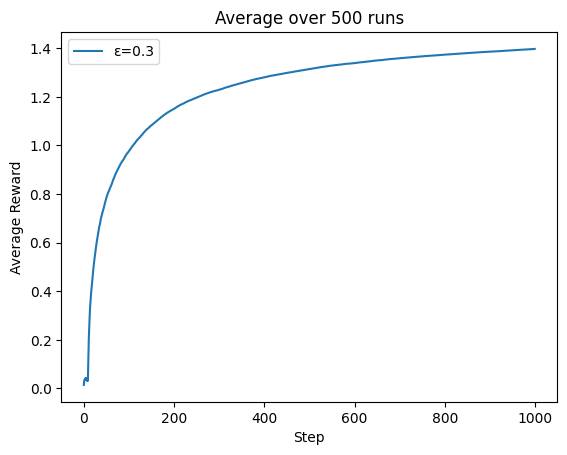

In [22]:

runs = 500          # large number
steps = 1000
n_arms = 10
rng_master = np.random.default_rng(seed)
avg_rewards_all = {eps: np.zeros(steps) for eps in epsilons}

for run in range(runs):
  env = BanditEnv(n=n_arms, seed=run, nonstationary=False)
  agent = UCBAgent(n=n_arms, rng=rng_master, c=2.0)
  for t in range(steps):
    a = agent.act()
    r = env.step(a)
    agent.update(a, r)
    avg_rewards_all[eps][t] += r
avg_rewards_all[eps] /= runs

plt.figure()
avg_reward = np.cumsum(avg_rewards_all[eps]) / np.arange(1, steps+1)
plt.plot(avg_reward, label=f'ε={eps}')
plt.xlabel('Step'); plt.ylabel('Average Reward')
plt.title(f'Average over {runs} runs')
plt.legend()
plt.show()


### Version con "epsilon=0.1", "c=2.0", "tau=0.1"

In [32]:
def run(env, agent, steps=2000):
    rewards = np.zeros(steps, dtype=float)
    optimal = np.zeros(steps, dtype=int)

    # identify the true best arm for % optimal plot
    true_best = int(np.argmax(env.mu))

    for t in range(steps):
        a = agent.act()
        r = env.step(a)
        agent.update(a, r)
        rewards[t] = r
        optimal[t] = (a == true_best)
    return rewards, optimal

# Example usage
n, steps, seed = 10, 2000, 7
rng_master = np.random.default_rng(seed)

env = BanditEnv(n=n, seed=seed, nonstationary=False)
agent_eps  = EpsilonGreedyAgent(n, rng=rng_master, epsilon=0.1)
re_eps, op_eps = run(env, agent_eps, steps=steps)

env = BanditEnv(n=n, seed=seed, nonstationary=False)
agent_ucb  = UCBAgent(n, rng=rng_master, c=2.0)
re_ucb, op_ucb = run(env, agent_ucb, steps=steps)

env = BanditEnv(n=n, seed=seed, nonstationary=False)
agent_soft = SoftmaxAgent(n, rng=rng_master, tau=0.1)
re_soft, op_soft = run(env, agent_soft, steps=steps)


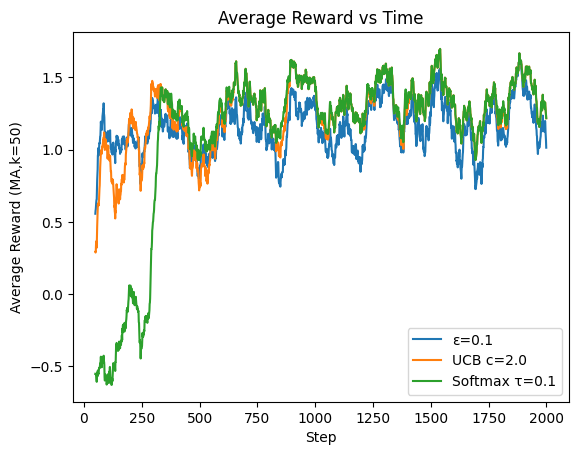

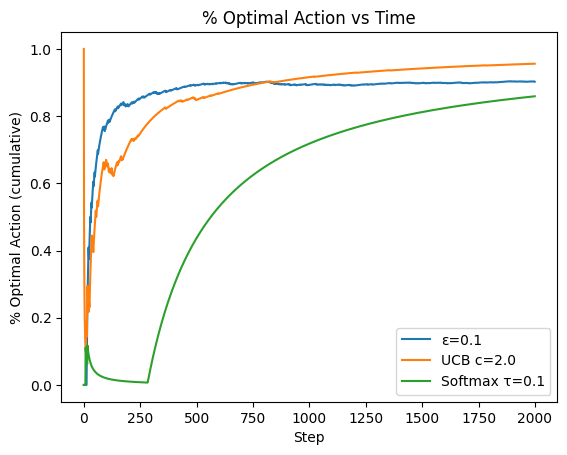

In [33]:
import matplotlib.pyplot as plt
def moving_average(x, k=50):
    k = max(1, int(k))
    c = np.cumsum(np.insert(x, 0, 0.0))
    y = (c[k:] - c[:-k]) / k
    return np.concatenate([np.full(k-1, np.nan), y])

plt.figure()
plt.plot(moving_average(re_eps),  label="ε=0.1")
plt.plot(moving_average(re_ucb),  label="UCB c=2.0")
plt.plot(moving_average(re_soft), label="Softmax τ=0.1")
plt.xlabel("Step"); plt.ylabel("Average Reward (MA,k=50)"); plt.title("Average Reward vs Time"); plt.legend(); plt.show()

plt.figure()
for lab, opt in [("ε=0.1", op_eps), ("UCB c=2.0", op_ucb), ("Softmax τ=0.1", op_soft)]:
    pct = np.cumsum(opt) / np.arange(1, len(opt)+1)
    plt.plot(pct, label=lab)
plt.xlabel("Step"); plt.ylabel("% Optimal Action (cumulative)"); plt.title("% Optimal Action vs Time"); plt.legend(); plt.show()


### Version con "epsilon=0.0", "c=1.0", "tau=0.0"

In [34]:
def run(env, agent, steps=2000):
    rewards = np.zeros(steps, dtype=float)
    optimal = np.zeros(steps, dtype=int)

    # identify the true best arm for % optimal plot
    true_best = int(np.argmax(env.mu))

    for t in range(steps):
        a = agent.act()
        r = env.step(a)
        agent.update(a, r)
        rewards[t] = r
        optimal[t] = (a == true_best)
    return rewards, optimal

# Example usage
n, steps, seed = 10, 2000, 7
rng_master = np.random.default_rng(seed)

env = BanditEnv(n=n, seed=seed, nonstationary=False)
agent_eps  = EpsilonGreedyAgent(n, rng=rng_master, epsilon=0.0)
re_eps, op_eps = run(env, agent_eps, steps=steps)

env = BanditEnv(n=n, seed=seed, nonstationary=False)
agent_ucb  = UCBAgent(n, rng=rng_master, c=1.0)
re_ucb, op_ucb = run(env, agent_ucb, steps=steps)

env = BanditEnv(n=n, seed=seed, nonstationary=False)
agent_soft = SoftmaxAgent(n, rng=rng_master, tau=0.0)
re_soft, op_soft = run(env, agent_soft, steps=steps)


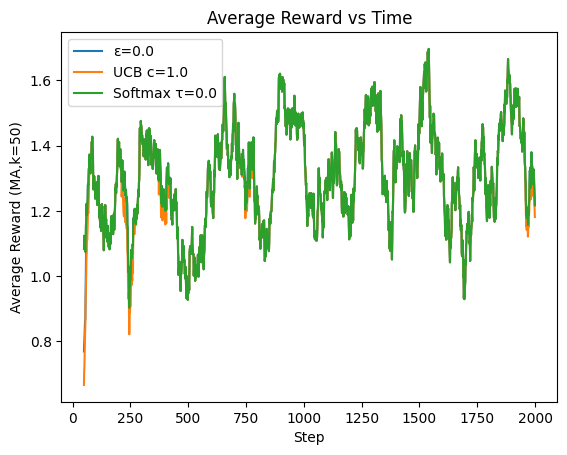

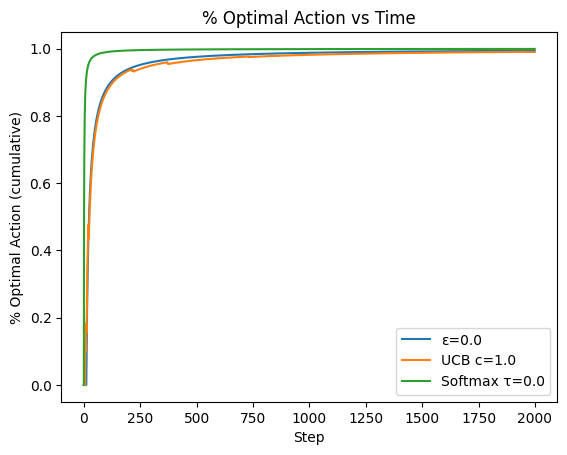

In [35]:
import matplotlib.pyplot as plt
def moving_average(x, k=50):
    k = max(1, int(k))
    c = np.cumsum(np.insert(x, 0, 0.0))
    y = (c[k:] - c[:-k]) / k
    return np.concatenate([np.full(k-1, np.nan), y])

plt.figure()
plt.plot(moving_average(re_eps),  label="ε=0.0")
plt.plot(moving_average(re_ucb),  label="UCB c=1.0")
plt.plot(moving_average(re_soft), label="Softmax τ=0.0")
plt.xlabel("Step"); plt.ylabel("Average Reward (MA,k=50)"); plt.title("Average Reward vs Time"); plt.legend(); plt.show()

plt.figure()
for lab, opt in [("ε=0.0", op_eps), ("UCB c=1.0", op_ucb), ("Softmax τ=0.0", op_soft)]:
    pct = np.cumsum(opt) / np.arange(1, len(opt)+1)
    plt.plot(pct, label=lab)
plt.xlabel("Step"); plt.ylabel("% Optimal Action (cumulative)"); plt.title("% Optimal Action vs Time"); plt.legend(); plt.show()


### Version con "epsilon=0.3", "c=3.0", "tau=0.3"

In [36]:
def run(env, agent, steps=2000):
    rewards = np.zeros(steps, dtype=float)
    optimal = np.zeros(steps, dtype=int)

    # identify the true best arm for % optimal plot
    true_best = int(np.argmax(env.mu))

    for t in range(steps):
        a = agent.act()
        r = env.step(a)
        agent.update(a, r)
        rewards[t] = r
        optimal[t] = (a == true_best)
    return rewards, optimal

# Example usage
n, steps, seed = 10, 2000, 7
rng_master = np.random.default_rng(seed)

env = BanditEnv(n=n, seed=seed, nonstationary=False)
agent_eps  = EpsilonGreedyAgent(n, rng=rng_master, epsilon=0.3)
re_eps, op_eps = run(env, agent_eps, steps=steps)

env = BanditEnv(n=n, seed=seed, nonstationary=False)
agent_ucb  = UCBAgent(n, rng=rng_master, c=3.0)
re_ucb, op_ucb = run(env, agent_ucb, steps=steps)

env = BanditEnv(n=n, seed=seed, nonstationary=False)
agent_soft = SoftmaxAgent(n, rng=rng_master, tau=0.3)
re_soft, op_soft = run(env, agent_soft, steps=steps)


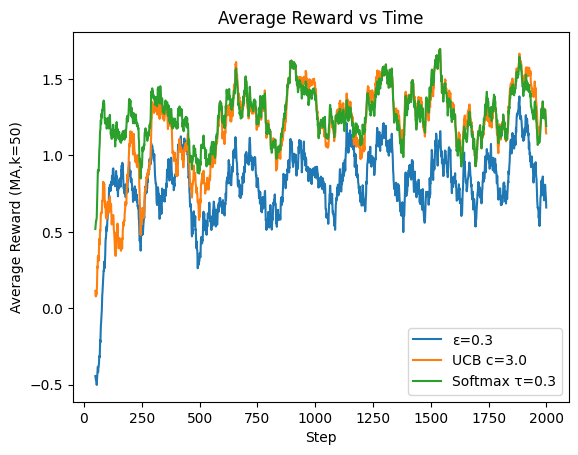

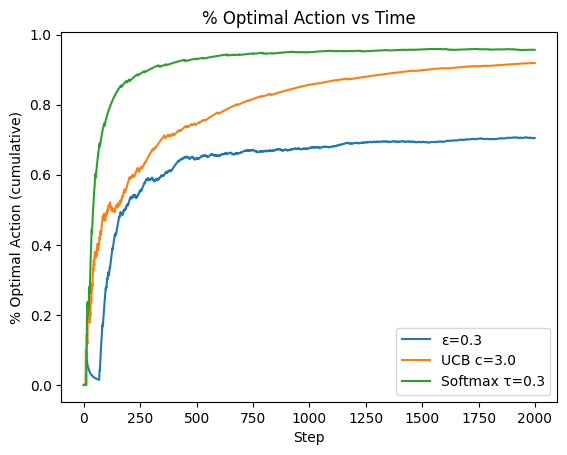

In [37]:
import matplotlib.pyplot as plt
def moving_average(x, k=50):
    k = max(1, int(k))
    c = np.cumsum(np.insert(x, 0, 0.0))
    y = (c[k:] - c[:-k]) / k
    return np.concatenate([np.full(k-1, np.nan), y])

plt.figure()
plt.plot(moving_average(re_eps),  label="ε=0.3")
plt.plot(moving_average(re_ucb),  label="UCB c=3.0")
plt.plot(moving_average(re_soft), label="Softmax τ=0.3")
plt.xlabel("Step"); plt.ylabel("Average Reward (MA,k=50)"); plt.title("Average Reward vs Time"); plt.legend(); plt.show()

plt.figure()
for lab, opt in [("ε=0.3", op_eps), ("UCB c=3.0", op_ucb), ("Softmax τ=0.3", op_soft)]:
    pct = np.cumsum(opt) / np.arange(1, len(opt)+1)
    plt.plot(pct, label=lab)
plt.xlabel("Step"); plt.ylabel("% Optimal Action (cumulative)"); plt.title("% Optimal Action vs Time"); plt.legend(); plt.show()


### Reflexión Breve

El dilema de exploración-explotación es el reto fundamental en la configuración de un problema de bandits: la exploración se utiliza para aprender sobre el mundo, mientras que la explotación se utiliza para obtener recompensas. Para el caso de ε-greedy, el valor de ε corresponde literalmente a “qué tan grande sea la exploración”. En mis pruebas, ε=0.1 fue el valor que pareció rendir mejor: con ε=0.0 me quedé estancadode a veces en un brazo subóptimo (no estoy explorando lo suficiente al inicio, pero el rendimiento en términos de recompensa promedio es mejor en las pruebas a largo plazo) y con ε=0.3 estoy explorando en exceso tras un porcentaje de acción óptima bajo y un rendimiento promedio en la parte final bastante bajo. Con ε=0.1, sin embargo, obtengo el valor más alto en la recompensa promedio y escalo rápido en el porcentaje de acción óptima.

En cuanto al algoritmo UCB, el parámetro c determina la “bonificación optimista” multiplicando el valor de la raíz cuadrada que penaliza el número de veces que se ha escogido un brazo en particular antes de su exploración. Si utilizo un valor de c muy bajo, no exploro lo suficiente y el proceso de aprendizaje se estanca en la parte inferior de la recompensa promedio; si c es demasiado alto, exploro en exceso y el aprendizaje es excesivamente conservador. Un c de entre 1.4 a 2.0 parece ser el punto en el cual obtengo el mejor rendimiento: rapidez en el proceso de aprendizaje y una estabilización alta.

En el caso del Softmax, τ es la “temperatura”: si τ es muy grande, elige con semejanza a una UCB bajando la probabilidad en todas las acciones (mucha exploración) y el número de veces que escojo se distribuye más equitativamente al ser escaneadas por el algoritmo. Si τ es muy bajo, se asemeja al greedy y eventualmente me quedaré con una sola acción. Sin embargo, eso no evita que inicialmente realice más escaneo en los brazos, solo me permite una mayor convergencia en el porcentaje de acción óptima. Un τ de alrededor de 0.1 proporciona un rendimiento aceptable, limitando la diversificación inicial y posteriormente centrando las selecciones en la parte final.

En conclusión, los mejores valores en cada caso son aquellos que (1) tienen la mayor recompensa promedio en la parte final y (2) conservan un elevadísimo porcentaje de acción óptima (entre 90% y 95%.) a la menor cantidad de pasos para converger.